## XModalix Workbook

#### IMPORTS

In [1]:
import os
from autoencodix.configs.default_config import DataConfig, DataInfo, DefaultConfig
from autoencodix.configs.xmodalix_config import XModalixConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


#### GLOBALS
**ATTENTION**
Be sure to have the appropriate files, or adjust paths and make your own config

In [2]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
    checkpoint_interval=25,
    loss_reduction="sum",
    class_param="early",
    epochs=5,
    beta=0.01,
    gamma=2,
    delta_class=0.0,
    delta_pair=3,
    learning_rate=0.001,
    k_filter=1000,
    latent_dim=8,
    batch_size=16,
    # blablabla="",
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
                scaling="MINMAX",
                translate_direction="to",
                pretrain_epochs=30,
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                scaling="MINMAX",
                translate_direction="from",
            ),
            "RNA2": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

### Run Xmodalix with defined config
- .run() does not work yet, because we dont have a visualizer, so we run it step by step

In [3]:
%env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [4]:
xmodalix = acx.XModalix(config=img_config)
xmodalix.preprocess()
xmodalix.fit()
result = xmodalix.predict()

Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to' pretrain_epochs=30
Checking data type: RNA
Checking data type: RNA2
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/base/_base_pipeline.py:189: UserWarning: Your config is of type: <class 'autoencodix.configs.default_config.DefaultConfig'>, for this pipeline the default params of: <class 'autoencodix.configs.xmodalix_config.XModalixConfig'> work best
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_filter.py:102: UserWarning: WARNING: k is None or greater than number of columns, keeping all features.
  warnings.warn(
/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/data/_filter.py:102: UserWarning: WARNING: k is None or greater than number of c

Successfully loaded 260 images for IMG
--- Running Pairing-Aware Split ---
Identified 260 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
key: train, type: <class 'dict'>
key: valid, type: <class 'dict'>
key: test, type: <class 'dict'>
Check if we need to pretrain: multi_bulk.RNA
pretrain epochs : 0
No pretraining for multi_bulk.RNA
Check if we need to pretrain: multi_bulk.RNA2
pretrain epochs : 0
No pretraining for multi_bulk.RNA2
Check if we need to pretrain: img.IMG
pretrain epochs : 30
Starting Pretraining for: img.IMG with <class 'autoencodix.trainers._general_trainer.GeneralTrainer'>
Epoch 1 - Train Loss: 88530.9343
Sub-losses: recon_loss: 88375.6890, var_loss: 155.2456, anneal_factor: 0.0000, effective_be

## Getting Translation and Sample Ids for all splits

### Loading and Saving XModalix
- works like for other pipelines too, can be used to run another predict pairing also

In [5]:
len(xmodalix._datasets.train.datasets["multi_bulk.RNA"])

182

In [6]:
loader = xmodalix._trainer._trainloader
for batch in loader:
    print(batch)
    break

{'multi_bulk.RNA': {'data': tensor([[0.0000, 0.4194, 0.0000,  ..., 0.0070, 0.0000, 0.0000],
        [0.5822, 0.4178, 0.7997,  ..., 0.7713, 0.4908, 0.9262],
        [0.1357, 0.2809, 0.2640,  ..., 0.2498, 0.1078, 0.0061],
        ...,
        [0.9388, 0.5028, 0.7559,  ..., 0.8390, 0.8411, 1.0000],
        [0.8615, 0.6513, 0.8035,  ..., 0.8529, 0.9338, 0.9923],
        [0.1833, 0.2331, 0.3077,  ..., 0.2807, 0.2110, 0.0044]],
       device='mps:0'), 'metadata':                    img_paths extra_class_labels early
T_52    ALY-2_SYS721_t52.tif                 52   '0'
T_210  ALY-2_SYS721_t210.tif                210   '0'
T_106  ALY-2_SYS721_t106.tif                106   '0'
T_159  ALY-2_SYS721_t159.tif                159   '0'
T_83    ALY-2_SYS721_t83.tif                 83   '0'
T_219  ALY-2_SYS721_t219.tif                219   '0'
T_132  ALY-2_SYS721_t132.tif                132   '0'
T_117  ALY-2_SYS721_t117.tif                117   '0'
T_1      ALY-2_SYS721_t1.tif                  1   '1

In [7]:
f = next(iter(batch))
f

'multi_bulk.RNA'

In [8]:
xmodalix.save("xmodalix.pkl")

Pipeline object saved successfully.
Preprocessor saved successfully.
Model state saved successfully.


In [9]:
xmodalix = acx.XModalix.load("xmodalix.pkl")

Attempting to load a pipeline from xmodalix.pkl...
Pipeline object loaded successfully. Actual type: XModalix
Preprocessor loaded successfully.
Model state loaded successfully.


### Inspect X-Modalix Result

In [10]:
r = xmodalix.result


Trainingdynamics in result are a dict with keys for each datamodality, the get interface works like for the other pipelines.
We have the special keys:
- translation which is the actual translated reconstruction or the from_latent space for the latentspace dynamic

In [11]:
r.reconstructions.get(epoch=-1, split="test").keys()

dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG', 'translation', 'reference_img.IMG_to_img.IMG'])

We have latentspaces for the test set for each modality, not only for the translation pairing

In [12]:
r.latentspaces.get(epoch=-1, split="test")

{'multi_bulk.RNA': array([[-1.7648869e+00,  1.0565214e+00, -5.0457513e-01, -3.5486782e-01,
         -1.9515516e+00,  9.2107826e-01, -1.1766787e+00,  6.0304612e-01],
        [ 1.6745050e+00,  7.9192150e-01,  3.2367370e-01,  1.8816327e-01,
         -8.4473521e-01,  4.4298429e-02, -1.4733220e+00, -1.3391210e+00],
        [-9.6189052e-01,  1.2020863e+00,  5.9987307e-03,  3.8215351e-01,
         -1.1878818e+00, -8.9367020e-01,  6.1303347e-01,  8.7493378e-01],
        [ 2.3513396e-01,  4.5765948e-01,  6.2573409e-01,  9.3790346e-01,
          1.0435344e+00,  1.5893102e-02,  8.7236661e-01,  8.9750344e-01],
        [-9.8335063e-01,  6.2059051e-01,  1.7020104e+00,  1.3203685e+00,
         -4.6469530e-01, -5.0962657e-02,  6.9092339e-01,  1.2721241e+00],
        [-7.2586221e-01,  3.2209426e-01, -1.7883893e+00,  3.4834599e+00,
         -4.1644344e-01,  6.9236666e-02,  1.5214281e+00,  2.2093725e-01],
        [ 9.8253238e-01,  7.6596010e-01, -1.2237151e+00,  4.2110765e-01,
          1.2167008e+00, -1

We also provide the andata interface for the translate latentspace (from_modality)

In [13]:
r.adata_latent.obs_names

Index(['T_102', 'T_11', 'T_115', 'T_116', 'T_123', 'T_127', 'T_13', 'T_133',
       'T_134', 'T_139', 'T_145', 'T_151', 'T_155', 'T_165', 'T_17', 'T_176',
       'T_180', 'T_185', 'T_191', 'T_195', 'T_196', 'T_201', 'T_203', 'T_204',
       'T_205', 'T_21', 'T_213', 'T_216', 'T_218', 'T_225', 'T_242', 'T_246',
       'T_25', 'T_253', 'T_255', 'T_30', 'T_32', 'T_34', 'T_36', 'T_4', 'T_40',
       'T_62', 'T_66', 'T_72', 'T_74', 'T_75', 'T_86', 'T_9', 'T_91', 'T_92',
       'T_97', 'T_99'],
      dtype='object')

And we also support the final_reconstruction attribute that returns the same datastructure as the input data, but switches the actual data with the translated reconstruction (for the translted modality, the rest is the same as the input data)

In [14]:
final_rec = r.final_reconstruction.datasets["img.IMG"]
inputimg = xmodalix.result.datasets.test.datasets["img.IMG"]

## Vis 2D aligned latent development

In [15]:
## from old autoecodix framework
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_translate_latent(
    # cfg, -> removed
    embedding,
    color_param,
    style_param=None,
    save_fig="",
):
    """
    Creates a 2D visualization of the 2D embedding of the latent space.
    ARGS:
        cfg (dict): config dictionary
        embedding (pd.DataFrame): embedding on which is visualized. Assumes prior 2D dimension reduction.
        color_param (str): Clinical parameter to color scatter plot
        style_param (str): Parameter e.g. "Translate" to facet scatter plot
        save_fig (str): File path for saving the plot. Use appropriate file
                        endings to specify image type (e.g. '*.png')
    RETURNS:
        fig (seaborn.FacetGrid): Figure handle

    """
    labels = embedding[color_param]
    # logger = getlogger(cfg)
    numeric = False
    if not (type(labels[0]) is str):
        if len(np.unique(labels)) > 3:
            # if not cfg["PLOT_NUMERIC"]:
            # print(
            #     f"The provided label column is numeric and converted to categories."
            # )
            # labels = pd.qcut(
            #     labels, q=4, labels=["1stQ", "2ndQ", "3rdQ", "4thQ"]
            # ).astype(str)
            # else:
            numeric = True
        else:
            labels = [str(x) for x in labels]

    # check if label or embedding is longerm and duplicate the shorter one
    if len(labels) < embedding.shape[0]:
        print(
            "Given labels do not have the same length as given sample size. Labels will be duplicated."
        )
        labels = [
            label for label in labels for _ in range(embedding.shape[0] // len(labels))
        ]
    elif len(labels) > embedding.shape[0]:
        labels = list(set(labels))

    if not style_param == None:
        embedding[color_param] = labels
        if numeric:
            palette = "bwr"
        else:
            palette = None
        plot = sns.relplot(
            data=embedding,
            x="DIM1",
            y="DIM2",
            hue=color_param,
            palette=palette,
            col=style_param,
            style=style_param,
            markers=True,
            alpha=0.4,
            ec="black",
            height=10,
            aspect=1,
            s=150,
        )

    if len(save_fig) > 0:
        plot.savefig(save_fig, bbox_inches="tight")

    return plot

In [16]:
## Collect all metadata and latent spaces from datasets
clin_data = []
latent_data = []

for split in ["train", "test", "valid"]:
    split_ds = getattr(r.datasets, split, None)
    if split_ds is not None:
        for key, ds in split_ds.datasets.items():
            df_latent = r.get_latent_df(epoch=-1, split=split, modality=key)
            df_latent["modality"] = key
            df_latent["sample_ids"] = (
                df_latent.index
            )  # Each sample can occur multiple times in latent space
            latent_data.append(df_latent)
            if hasattr(ds, "metadata") and ds.metadata is not None:
                df = ds.metadata.copy()
                # Add sample_ids as a column if it's the index
                if df.index.name == "sample_ids" and "sample_ids" not in df.columns:
                    print(key)
                    print(df)
                    df = df.reset_index()
                df["split"] = split
                df["modality"] = key
                clin_data.append(df)

if latent_data and clin_data:
    latent_data = pd.concat(latent_data, axis=0, ignore_index=True)
    clin_data = pd.concat(clin_data, axis=0, ignore_index=True)
    if "sample_ids" in clin_data.columns:
        clin_data = clin_data.drop_duplicates(subset="sample_ids").set_index(
            "sample_ids"
        )
else:
    latent_data = pd.DataFrame()
    clin_data = pd.DataFrame()

img.IMG
                        img_paths  extra_class_labels early
sample_ids                                                 
T_114       ALY-2_SYS721_t114.tif                 114   '0'
T_100       ALY-2_SYS721_t100.tif                 100   '0'
T_26         ALY-2_SYS721_t26.tif                  26   '1'
T_128       ALY-2_SYS721_t128.tif                 128   '0'
T_129       ALY-2_SYS721_t129.tif                 129   '0'
...                           ...                 ...   ...
T_252       ALY-2_SYS721_t252.tif                 252   '0'
T_247       ALY-2_SYS721_t247.tif                 247   '0'
T_125       ALY-2_SYS721_t125.tif                 125   '0'
T_131       ALY-2_SYS721_t131.tif                 131   '0'
T_119       ALY-2_SYS721_t119.tif                 119   '0'

[182 rows x 3 columns]
img.IMG
                        img_paths  extra_class_labels early
sample_ids                                                 
T_32         ALY-2_SYS721_t32.tif                  32   '1'


In [17]:
from umap import UMAP

## Make 2D Embedding with UMAP
if latent_data.drop(columns=["sample_ids", "modality"]).shape[1] > 2:
    reducer = UMAP(n_components=2)
    embedding = pd.DataFrame(
        reducer.fit_transform(latent_data.drop(columns=["sample_ids", "modality"]))
    )
    embedding.columns = ["DIM1", "DIM2"]
    embedding["sample_ids"] = latent_data["sample_ids"]
    embedding["modality"] = latent_data["modality"]
else:
    embedding = latent_data

# Merge with clinical data via sample_ids
embedding = embedding.merge(
    clin_data.drop(columns=["modality"]), on="sample_ids", how="left"
)

embedding

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,DIM1,DIM2,sample_ids,modality,img_paths,extra_class_labels,early,split
0,10.584869,10.130578,T_1,multi_bulk.RNA,ALY-2_SYS721_t1.tif,1,'1',train
1,10.237947,8.514357,T_10,multi_bulk.RNA,ALY-2_SYS721_t10.tif,10,'1',train
2,10.046599,10.069765,T_100,multi_bulk.RNA,ALY-2_SYS721_t100.tif,100,'0',train
3,10.395110,10.031279,T_101,multi_bulk.RNA,ALY-2_SYS721_t101.tif,101,'0',train
4,10.828659,7.224734,T_103,multi_bulk.RNA,ALY-2_SYS721_t103.tif,103,'0',train
...,...,...,...,...,...,...,...,...
775,5.730021,4.333675,T_48,img.IMG,ALY-2_SYS721_t48.tif,48,'0',valid
776,5.770784,4.263559,T_63,img.IMG,ALY-2_SYS721_t63.tif,63,'0',valid
777,4.832378,4.279817,T_77,img.IMG,ALY-2_SYS721_t77.tif,77,'0',valid
778,5.312879,3.591667,T_78,img.IMG,ALY-2_SYS721_t78.tif,78,'0',valid


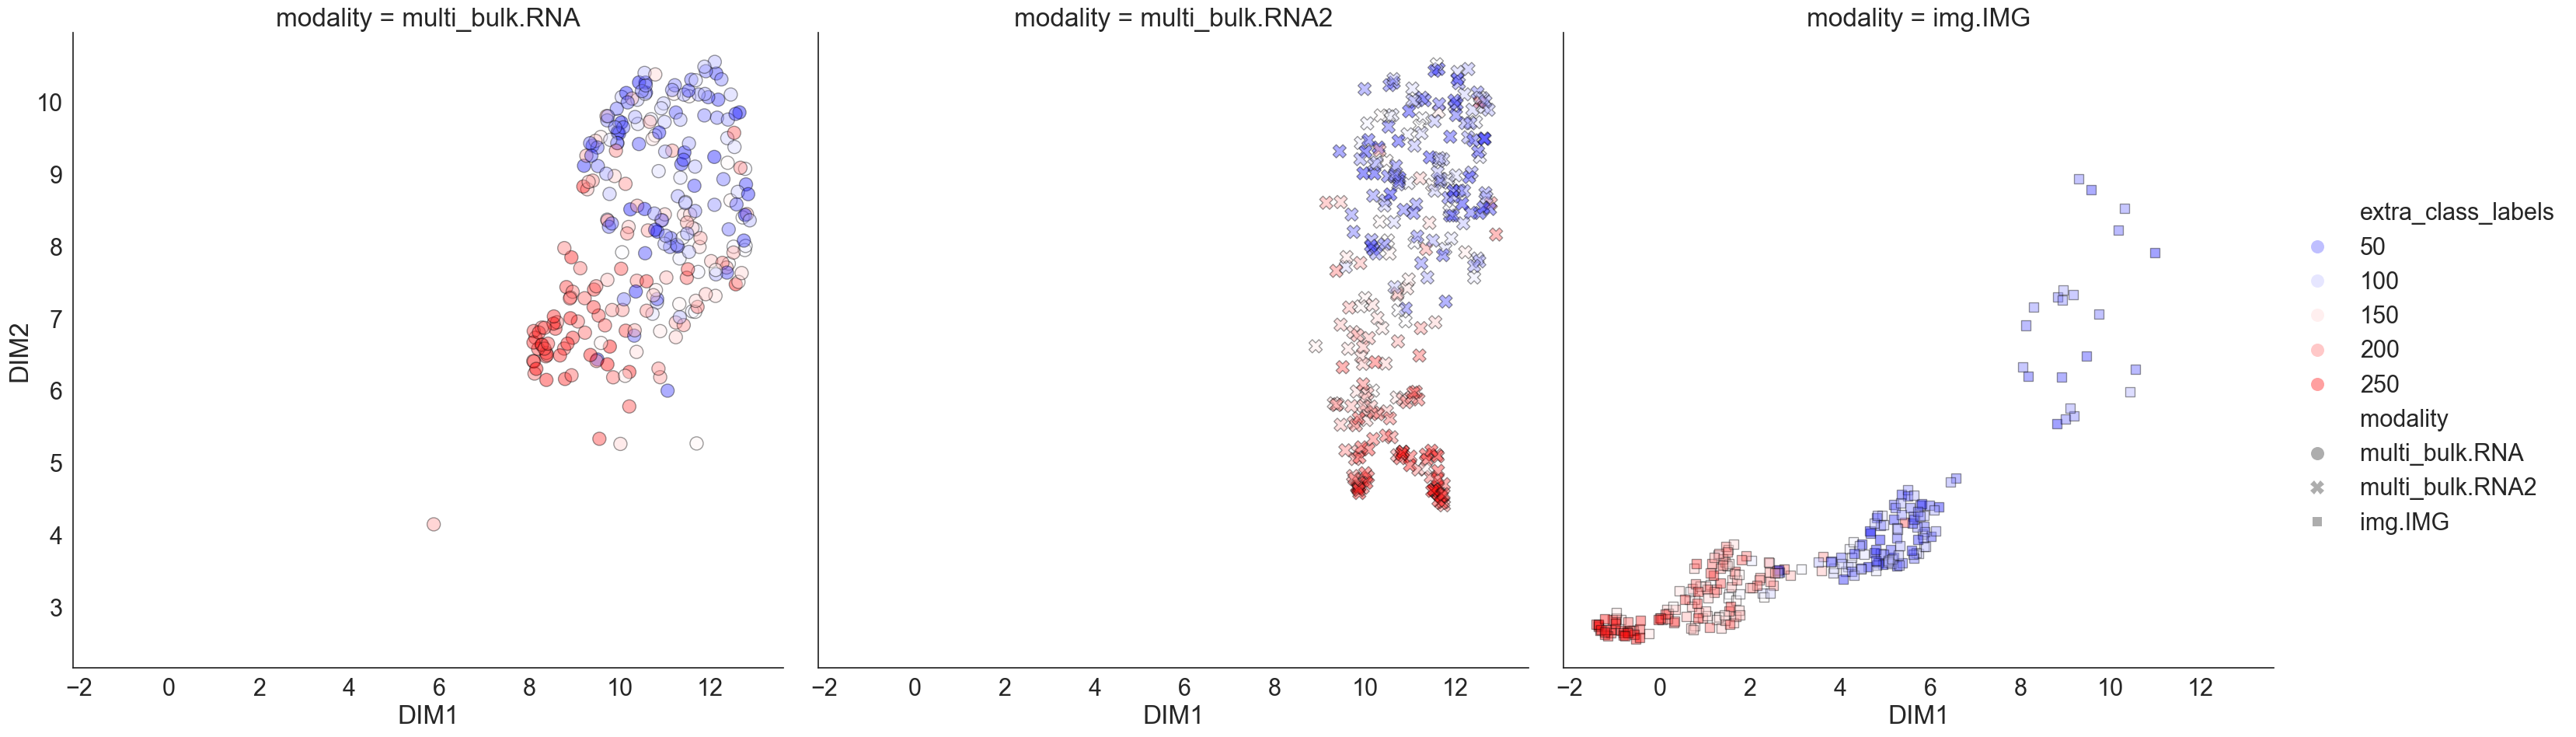

In [18]:
param = "extra_class_labels"
sns.set_theme(font_scale=2)
sns.set_style("white")

plot = plot_translate_latent(
    embedding=embedding,
    color_param=param,
    style_param="modality",
)

In [19]:
latent_data

,LatDim_0,LatDim_1,LatDim_2,LatDim_3,LatDim_4,LatDim_5,LatDim_6,LatDim_7,modality,sample_ids
0,-0.546178,-1.158180,-0.757334,0.220543,-0.973137,0.755726,1.617227,0.787722,multi_bulk.RNA,T_1
1,0.429616,2.391973,-0.599949,-0.693823,2.168555,-1.737696,0.206550,-1.319716,multi_bulk.RNA,T_10
2,-1.743715,1.611088,0.903105,-0.515978,-0.098332,0.181630,1.130628,0.089550,multi_bulk.RNA,T_100
3,-0.256222,0.867337,0.428096,-0.769018,0.439384,-0.013428,0.906333,-0.065382,multi_bulk.RNA,T_101
4,2.473989,-0.254952,1.343741,1.811311,-0.251011,0.552141,-0.284750,-0.209790,multi_bulk.RNA,T_103
...,...,...,...,...,...,...,...,...,...,...
775,-1.096258,6.202178,0.471290,1.103674,0.073010,-1.258047,1.232567,2.237104,img.IMG,T_48
776,0.364820,6.456915,2.026810,3.054790,-1.139044,0.771765,0.122902,-2.452152,img.IMG,T_63
777,-2.685755,4.667756,0.536310,4.838290,-0.234143,-1.658371,1.611923,-0.608710,img.IMG,T_77
778,2.243451,8.269324,0.255195,4.481353,-0.205628,1.765617,0.539504,1.432163,img.IMG,T_78


### Flexible Prediction
We train the Xmodalix with multiple data modalities, out of all these modalities, we can build any pair for translation byt passing the keys (as defined in your config or datapackage) to the predict method like:

In [20]:
result2 = xmodalix.predict(from_key="IMG", to_key="IMG")

dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG'])
dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG', 'translation', 'reference_img.IMG_to_img.IMG'])
dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG'])
dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG'])
dict_keys(['multi_bulk.RNA', 'multi_bulk.RNA2', 'img.IMG', 'translation', 'reference_img.IMG_to_img.IMG'])
Prediction complete.
Processing latent space results into a single AnnData object...
Identified source modality for latent space: 'multi_bulk.RNA'
  - Added 279 source feature IDs to .uns
Finished processing latent results.


### Inspecting losses
We save all losses in our result object, see the keys here:

In [21]:
result.sub_losses.keys()

dict_keys(['total_loss', 'adver_loss', 'aggregated_sub_losses', 'paired_loss', 'class_loss', 'multi_bulk.RNA.recon_loss', 'multi_bulk.RNA.var_loss', 'multi_bulk.RNA.anneal_factor', 'multi_bulk.RNA.effective_beta_factor', 'multi_bulk.RNA.loss', 'multi_bulk.RNA2.recon_loss', 'multi_bulk.RNA2.var_loss', 'multi_bulk.RNA2.anneal_factor', 'multi_bulk.RNA2.effective_beta_factor', 'multi_bulk.RNA2.loss', 'img.IMG.recon_loss', 'img.IMG.var_loss', 'img.IMG.anneal_factor', 'img.IMG.effective_beta_factor', 'img.IMG.loss', 'clf_loss'])

After selecting a subloss, this works like a standard TrainingDynamic

In [22]:
result.sub_losses.get("adver_loss")

TrainingDynamics()

### Visualizing a sample output
Note this is shown with only one epoch training, I've seen good results for 20 epochs of pretraining img and 30 epochs of normal training

In [23]:
img = result.reconstructions.get(split="test", epoch=-1)

In [24]:
img = img["translation"]

In [25]:
img.shape

(52, 1, 64, 64)

In [26]:
sample_img = img[0, :, :, :].squeeze()
sample_img.shape

(64, 64)

In [27]:
sample_img.max()

np.float32(0.6278275)

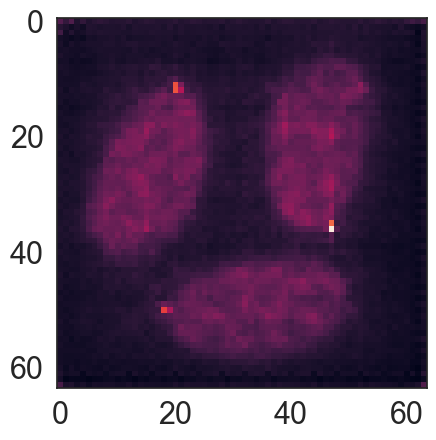

In [28]:
import matplotlib.pyplot as plt

plt.imshow(sample_img)

### Getting Info about pretraining
The pretraining is saved in sub_results in the result object

In [29]:
sub_res = result.sub_results
sub_res

{'multi_bulk.RNA': None,
 'multi_bulk.RNA2': None,
 'img.IMG': None,
 'pretrain.img.IMG': Result Object Public Attributes:
 ------------------------------
 latentspaces: TrainingDynamics object
 sample_ids: TrainingDynamics object
 reconstructions: TrainingDynamics object
 mus: TrainingDynamics object
 sigmas: TrainingDynamics object
 losses: TrainingDynamics object
 sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
 preprocessed_data: Tensor of shape (0,)
 model: ImageVAEArchitecture
 model_checkpoints: TrainingDynamics object
 datasets: DatasetContainer(train=None, valid=None, test=None)
 new_datasets: DatasetContainer(train=None, valid=None, test=None)
 adata_latent: AnnData object with n_obs × n_vars = 0 × 0
 final_reconstruction: None
 sub_results: None
 sub_reconstructions: None
 embedding_evaluation: Empty DataFrame
 Columns: []
 Index: []}

## Xmodal_loss Visualization
Vibe coded provisory loss visualization

In [30]:
result.sub_losses.keys()
result.sub_losses.get("img.IMG.var_loss").get()


{0: {'train': array(8.73631005e-06), 'valid': array(9.12078024e-06)},
 1: {'train': array(0.00047724), 'valid': array(0.00050572)},
 2: {'train': array(0.02291695), 'valid': array(0.02267434)},
 3: {'train': array(0.16981174), 'valid': array(0.17470734)},
 4: {'train': array(0.19219758), 'valid': array(0.20045382)}}

In [31]:
import matplotlib.pyplot as plt


def plot_losses(result):
    """
    Generates and displays plots for all relevant losses from a Result object.

    Args:
        result: Your custom result object containing the sub_losses attribute.
    """
    if not hasattr(result, "sub_losses"):
        print(
            "Error: The provided result object does not have a 'sub_losses' attribute."
        )
        return

    # 1. Get all loss keys and filter out the factors
    all_loss_keys = result.sub_losses.keys()
    keys_to_plot = [key for key in all_loss_keys if not key.endswith("_factor")]

    if not keys_to_plot:
        print("No valid loss keys found to plot.")
        return

    # 2. Iterate through each loss and create a plot
    for loss_name in keys_to_plot:
        try:
            # Retrieve the nested dictionary for the current loss
            loss_data = result.sub_losses.get(loss_name).get()

            # 3. Unpack the data into lists for plotting
            epochs = sorted(loss_data.keys())
            train_losses = [loss_data[epoch]["train"] for epoch in epochs]

            # Check if validation data exists before trying to plot it
            has_valid_data = all("valid" in loss_data[epoch] for epoch in epochs)
            if has_valid_data:
                valid_losses = [loss_data[epoch]["valid"] for epoch in epochs]

            # 4. Create the plot
            plt.figure(figsize=(10, 6))
            plt.plot(epochs, train_losses, "o-", label=f"Train ({loss_name})")
            if has_valid_data:
                plt.plot(epochs, valid_losses, "x-", label=f"Validation ({loss_name})")

            plt.title(f"Training and Validation Loss: {loss_name}")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid(True)
            plt.show()

        except (AttributeError, TypeError, KeyError) as e:
            print(f"Could not plot '{loss_name}'. Error retrieving data: {e}")


## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [32]:
import autoencodix as acx
from autoencodix.configs.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    checkpoint_interval=10,
    epochs=40,
    reconstruction_loss="bce",
    beta=0.1,
    scaling="MINMAX",
    anneal_function="logistic-late",
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                scaling="MINMAX",
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='MINMAX' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction=None pretrain_epochs=0
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
Successfully loaded 260 images for IMG
calling normalize image in _process_ing_to_img_case
--- Running Pairing-Aware Split ---
Identified 260 fully paired samples across all modalities.
Identified 0 samples present in at least one, but not all, modalities.
Successfully generated synchronized indices for all modalities.
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


Epoch 1 - Train Loss: 654088.9375
Sub-losses: recon_loss: 653960.6484, var_loss: 128.2899, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 92911.1172
Sub-losses: recon_loss: 92911.1172, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 640297.1875
Sub-losses: recon_loss: 639544.6328, var_loss: 752.5575, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 91410.4688
Sub-losses: recon_loss: 91410.4688, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 631659.2109
Sub-losses: recon_loss: 630046.6562, var_loss: 1612.5509, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 3 - Valid Loss: 89427.2344
Sub-losses: recon_loss: 89427.2344, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 4 - Train Loss: 623936.6328
Sub-losses: recon_loss: 621135.7734, var_loss: 2800.8502, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Ep

In [33]:
imagix.config.data_case

<DataCase.IMG_TO_IMG: 'IMG<->IMG'>

In [34]:
imagix.predict()

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: ImageVAEArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._image_dataset.ImageDataset object at 0x3793e8ee0>, valid=<autoencodix.data._image_dataset.ImageDataset object at 0x3786c4d00>, test=<autoencodix.data._image_dataset.ImageDataset object at 0x3786c5900>)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 52 × 16
    uns: 'var_names'
final_reconstruction: <autoencodix

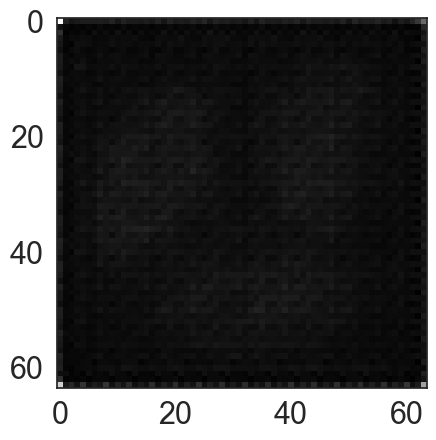

In [35]:
import matplotlib.pyplot as plt

r2 = imagix.result
r2.final_reconstruction
sample_img = r2.final_reconstruction.data[17, :, :, :]
sample_img = sample_img.squeeze()

plt.imshow(sample_img, cmap="grey")

In [36]:
sample_img

tensor([[0.1279, 0.0185, 0.0122,  ..., 0.0198, 0.0290, 0.0532],
        [0.0106, 0.0053, 0.0031,  ..., 0.0033, 0.0040, 0.0204],
        [0.0251, 0.0031, 0.0055,  ..., 0.0067, 0.0062, 0.0114],
        ...,
        [0.0085, 0.0076, 0.0038,  ..., 0.0051, 0.0047, 0.0179],
        [0.0256, 0.0035, 0.0041,  ..., 0.0024, 0.0064, 0.0114],
        [0.1045, 0.0147, 0.0212,  ..., 0.0093, 0.0156, 0.0813]])

In [37]:
sample_img = r2.reconstructions.get(split="test", epoch=-1)
sample_img = sample_img[0, :, :, :]
sample_img = sample_img.squeeze()
sample_img.shape

(64, 64)

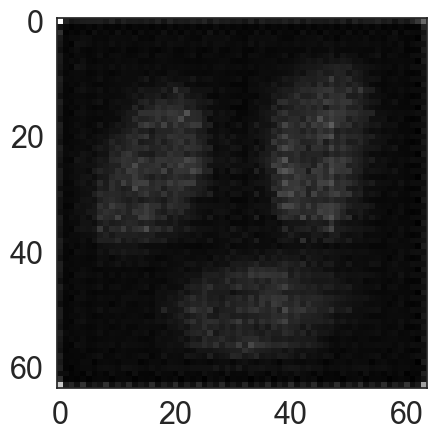

In [38]:
import matplotlib.pyplot as plt

plt.imshow(sample_img, cmap="grey")

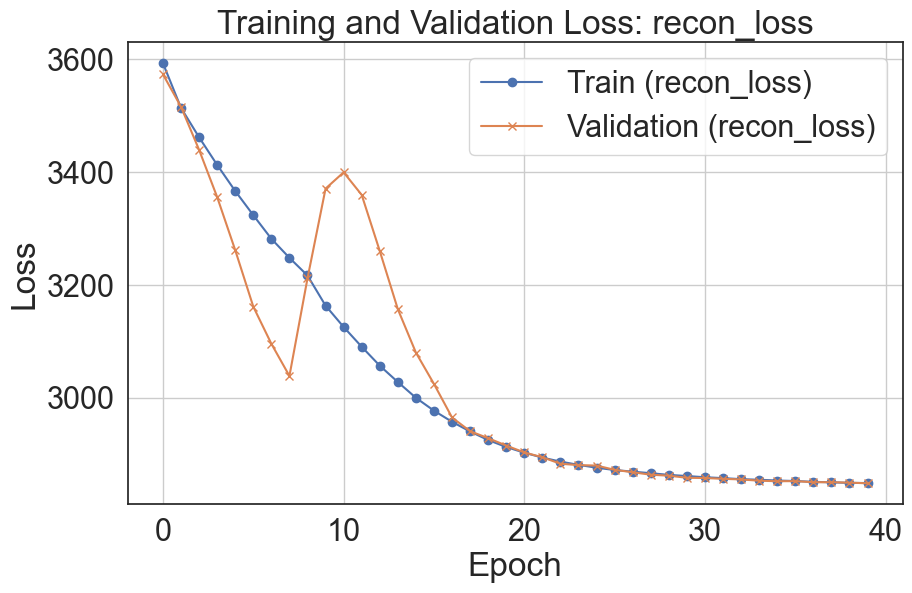

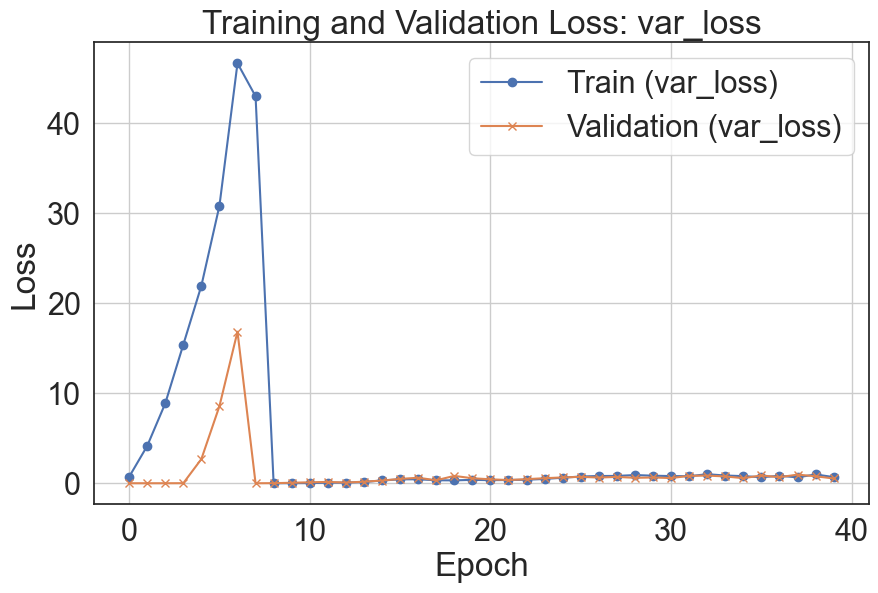

In [39]:
plot_losses(r2)

In [40]:
imagix._datasets.train.data[0]

tensor([[[0.0652, 0.0870, 0.0652,  ..., 0.0870, 0.0652, 0.0652],
         [0.0652, 0.0435, 0.0435,  ..., 0.0435, 0.0652, 0.0435],
         [0.0435, 0.0652, 0.0652,  ..., 0.0435, 0.0435, 0.0435],
         ...,
         [0.0217, 0.0435, 0.0435,  ..., 0.0435, 0.0217, 0.0217],
         [0.0435, 0.0435, 0.0435,  ..., 0.0217, 0.0217, 0.0217],
         [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0217, 0.0217]]])

In [41]:
loader = imagix._trainer._trainloader
for batch in loader:
    a = batch
    break

In [42]:
type(a)

list

a

In [43]:
len(a)

3

In [44]:
a[1].max()

tensor(1., device='mps:0')

## Unique Predict Ids
TODO test if results in result object are the same as in all_dyanmics

r.data


In [45]:
print(len(r.datasets.train.datasets["img.IMG"].data))
print(r.datasets.train.datasets["multi_bulk.RNA"].data.shape)
print(r.datasets.train.datasets["multi_bulk.RNA2"].data.shape)

182
torch.Size([182, 279])
torch.Size([182, 279])


In [46]:
r.latentspaces.get(epoch=-1, split="test")["multi_bulk.RNA"].shape
train_unique_ids = np.unique(r.sample_ids.get(epoch=-1, split="test")["multi_bulk.RNA"])
train_ids = r.sample_ids.get(epoch=-1, split="test")["multi_bulk.RNA"]
# remove duplicates ids, so that each id only occurs once, but if for example T_121 appears 3 times, keep only 1, but don't drop all instances of T_121
print(len(train_ids))
print(len(train_unique_ids))


52
52


In [47]:
# Step 1: Get unique IDs and first occurrence indices
unique_ids, first_idx = np.unique(train_ids, return_index=True)

# Step 2: Sort indices to preserve original order
first_idx_sorted = np.sort(first_idx)

# Unique IDs in order of first appearance
unique_ids_ordered = train_ids[first_idx_sorted]

In [48]:
first_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [49]:
unique_ids_ordered

array(['T_102', 'T_11', 'T_115', 'T_116', 'T_123', 'T_127', 'T_13',
       'T_133', 'T_134', 'T_139', 'T_145', 'T_151', 'T_155', 'T_165',
       'T_17', 'T_176', 'T_180', 'T_185', 'T_191', 'T_195', 'T_196',
       'T_201', 'T_203', 'T_204', 'T_205', 'T_21', 'T_213', 'T_216',
       'T_218', 'T_225', 'T_242', 'T_246', 'T_25', 'T_253', 'T_255',
       'T_30', 'T_32', 'T_34', 'T_36', 'T_4', 'T_40', 'T_62', 'T_66',
       'T_72', 'T_74', 'T_75', 'T_86', 'T_9', 'T_91', 'T_92', 'T_97',
       'T_99'], dtype='<U5')

In [ ]:
def test_sample_id_consistency(
    epoch_dynamics: List[Dict],
    split: str,
    sample_id: Any,
    dynamic_type: str,
    mod_name: str,
    result_obj: Any,
    cur_epoch: int,
) -> bool:
    """Tests if data for a specific sample_id is consistent after deduplication.
    Args:
        epoch_dynamics: List of dictionaries capturing dynamics for each batch.
        split: The data split name (e.g., 'train', 'valid', 'test').
        sample_id: The sample_id to check (e.g., 'xyz').
        dynamic_type: The data type to check (e.g., 'latentspaces', 'reconstructions').
        mod_name: The modality name (e.g., 'model1').
        result_obj: The Result object with attributes like latentspaces, reconstructions.
        cur_epoch: The current epoch number.
    Returns:
        bool: True if data is consistent, False otherwise.
    """
    # Step 1: Collect input data for the sample_id
    input_data = []
    input_indices = []
    for batch_idx, batch_data in enumerate(epoch_dynamics):
        if dynamic_type in batch_data and mod_name in batch_data[dynamic_type]:
            if "sample_ids" in batch_data and mod_name in batch_data["sample_ids"]:
                sample_ids = batch_data["sample_ids"][mod_name]
                data = batch_data[dynamic_type][mod_name]
                # Find indices where sample_id appears
                matches = np.where(sample_ids == sample_id)[0]
                for idx in matches:
                    input_data.append(data[idx])
                    input_indices.append((batch_idx, idx))

    if not input_data:
        print(
            f"Sample ID '{sample_id}' not found for {dynamic_type}/{mod_name} in input"
        )
        return False

    # Step 2: Run the dynamics_to_result method
    _dynamics_to_result(result_obj, split, epoch_dynamics)

    # Step 3: Get output data for the sample_id
    result_attr_map = {
        "latentspaces": result_obj.latentspaces,
        "reconstructions": result_obj.reconstructions,
        "sample_ids": result_obj.sample_ids,
        "mus": result_obj.mus,
        "sigmas": result_obj.sigmas,
    }
    result_data = result_attr_map.get(dynamic_type)
    if not result_data:
        print(f"No output data for {dynamic_type}")
        return False

    # Access deduplicated data
    deduplicated_data = result_data.get(epoch=result_obj._cur_epoch, split=split)
    if not deduplicated_data or mod_name not in deduplicated_data:
        print(f"No output data for {dynamic_type}/{mod_name}")
        return False

    output_data = deduplicated_data[mod_name]
    output_sample_ids = result_obj.sample_ids.get(
        epoch=result_obj._cur_epoch, split=split
    )
    if not output_sample_ids or mod_name not in output_sample_ids:
        print(f"No sample_ids in output for {mod_name}")
        return False

    output_idx = np.where(output_sample_ids[mod_name] == sample_id)[0]
    if len(output_idx) == 0:
        print(f"Sample ID '{sample_id}' not found in output for {mod_name}")
        return False
    elif len(output_idx) > 1:
        print(
            f"Warning: Sample ID '{sample_id}' appears multiple times in output (unexpected)"
        )
        return False

    output_data_for_id = output_data[output_idx[0]]

    # Step 4: Compare input and output data
    # Use the first occurrence from input (since np.unique keeps first occurrence)
    input_data_first = input_data[0]
    if isinstance(input_data_first, np.ndarray):
        is_equal = np.array_equal(input_data_first, output_data_for_id)
    else:
        is_equal = input_data_first == output_data_for_id  # For scalars or other types

    if not is_equal:
        print(f"Data mismatch for sample_id '{sample_id}' in {dynamic_type}/{mod_name}")
        print(f"Input: {input_data_first}")
        print(f"Output: {output_data_for_id}")
        return False

    print(
        f"Data for sample_id '{sample_id}' in {dynamic_type}/{mod_name} is consistent"
    )
    return True

In [ ]:
jfinal_data.keys()

dict_keys(['latentspaces', 'mus', 'reconstructions', 'sigmas', 'sample_ids'])

In [ ]:
deduplicated_data = {}

for dynamic_type in final_data:
    deduplicated_data[dynamic_type] = {}
    print(dynamic_type)

    for mod_name, batch_list in final_data[dynamic_type].items():
        print(mod_name)
        print(f"len of batch_list: {len(batch_list)}")
        print(f"bacht size: {len(batch_list[0])}")

        # Concatenate the batches for this modality
        concatenated = np.concatenate(batch_list)
        print(f"shape of concat: {concatenated.shape}")


latentspaces
multi_bulk.RNA
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
multi_bulk.RNA2
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
img.IMG
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
mus
multi_bulk.RNA
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
multi_bulk.RNA2
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
img.IMG
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
reconstructions
multi_bulk.RNA2
len of batch_list: 304
bacht size: 279
shape of concat: (84816,)
multi_bulk.RNA
len of batch_list: 304
bacht size: 279
shape of concat: (84816,)
img.IMG
len of batch_list: 304
bacht size: 1
shape of concat: (304, 64, 64)
translation
len of batch_list: 304
bacht size: 1
shape of concat: (304, 64, 64)
reference_img.IMG_to_img.IMG
len of batch_list: 304
bacht size: 1
shape of concat: (304, 64, 64)
sigmas
multi_bulk.RNA
len of batch_list: 304
bacht size: 8
shape of concat: (2432,)
multi_bulk.RNA2
len

ValueError: zero-dimensional arrays cannot be concatenated